In [6]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:
# import hr dataset with pandas
from google.colab import files

df = files.upload()

Saving fed_funds_rate_with_predictions.csv to fed_funds_rate_with_predictions.csv


In [7]:
df = pd.read_csv('fed_funds_rate_with_predictions.csv')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25692 entries, 0 to 25691
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        25692 non-null  object 
 1   SMA_filled  25692 non-null  float64
dtypes: float64(1), object(1)
memory usage: 401.6+ KB
None
       date  SMA_filled
0  7/1/1954        1.13
1  7/2/1954        1.25
2  7/3/1954        1.25
3  7/4/1954        1.25
4  7/5/1954        0.88


In [9]:
# Ensure 'date' is parsed as a datetime object
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any missing dates (optional)
if df['date'].isnull().sum() > 0:
    print("Warning: Some dates could not be parsed!")

# Data Exploration (optional check)
print(df.head())

        date  SMA_filled
0 1954-07-01        1.13
1 1954-07-02        1.25
2 1954-07-03        1.25
3 1954-07-04        1.25
4 1954-07-05        0.88


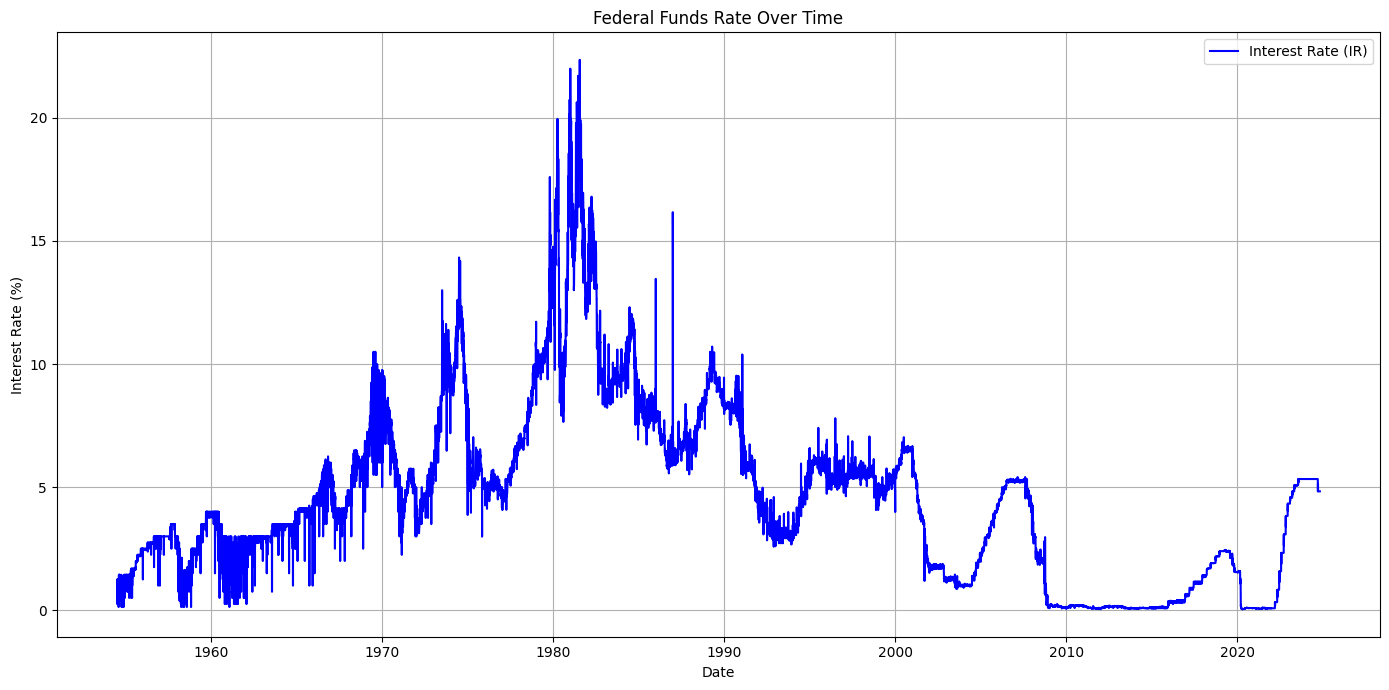

In [10]:
# Plot the Interest Rate (IR) over time
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['SMA_filled'], color='blue', label='Interest Rate (IR)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.title('Federal Funds Rate Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

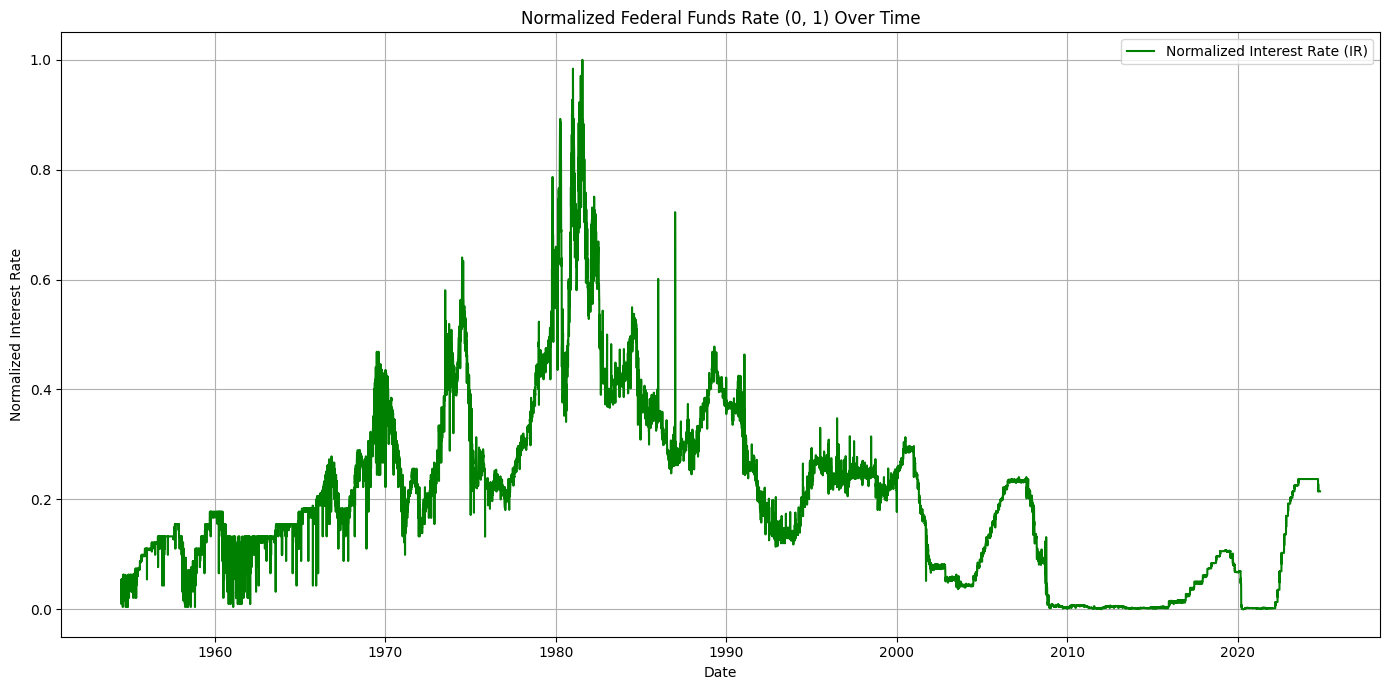

In [11]:
# Min-Max Normalization (0, 1)
min_value = df['SMA_filled'].min()
max_value = df['SMA_filled'].max()
df['SMA_filled_normalized'] = (df['SMA_filled'] - min_value) / (max_value - min_value)

# Plot the normalized Interest Rate (IR) over time
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['SMA_filled_normalized'], color='green', label='Normalized Interest Rate (IR)')
plt.xlabel('Date')
plt.ylabel('Normalized Interest Rate')
plt.title('Normalized Federal Funds Rate (0, 1) Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Implementing LSTM

In [ ]:
# Create sequences for LSTM
timesteps = 10
X = []
y = []

# Create sequences (X) and target values (y)
for i in range(timesteps, len(df)):
    X.append(df['SMA_filled_normalized'][i-timesteps:i].values)
    y.append(df['SMA_filled_normalized'][i])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X_train and X_test into 3D arrays (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the model
model = Sequential()

# LSTM layer 1 with dropout and batch normalization
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# LSTM layer 2 with dropout and batch normalization
model.add(LSTM(units=10))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Output layer
model.add(Dense(units=1))

# Compile the model with optimizer and loss function
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model (no early stopping)
model.fit(X_train, y_train, epochs=20, batch_size=2, verbose=1, validation_split=0.2)

# Predict using the trained model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Reshape predictions to 2D for inverse transformation
train_pred = train_pred.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)

# Inverse transform predictions and actual values to get them back to the original scale
scaler = MinMaxScaler()
scaler.fit(df['SMA_filled'].values.reshape(-1, 1))
train_pred = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train_inv, train_pred)
test_mse = mean_squared_error(y_test_inv, test_pred)

# Calculate Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_inv, train_pred)
test_mae = mean_absolute_error(y_test_inv, test_pred)

# Calculate Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate R-squared (R²)
train_r2 = r2_score(y_train_inv, train_pred)
test_r2 = r2_score(y_test_inv, test_pred)

# Calculate Variance of the errors (Residuals)
train_variance = np.var(y_train_inv - train_pred)
test_variance = np.var(y_test_inv - test_pred)

# Print metrics
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing Mean Squared Error: {test_mse}')
print(f'Training Mean Absolute Error (MAE): {train_mae}')
print(f'Testing Mean Absolute Error (MAE): {test_mae}')
print(f'Training Root Mean Squared Error (RMSE): {train_rmse}')
print(f'Testing Root Mean Squared Error (RMSE): {test_rmse}')
print(f'Training R-squared (R²): {train_r2}')
print(f'Testing R-squared (R²): {test_r2}')
print(f'Training Variance of Errors: {train_variance}')
print(f'Testing Variance of Errors: {test_variance}')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8218/8218 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - loss: 0.2077 - val_loss: 8.8679e-04
Epoch 2/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - loss: 0.0133 - val_loss: 0.1299
Epoch 3/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 140s 10ms/step - loss: 0.0124 - val_loss: 0.0486
Epoch 4/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - loss: 0.0121 - val_loss: 0.0011
Epoch 5/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 6/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - loss: 0.0124 - val_loss: 0.0010
Epoch 7/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 141s 10ms/step - loss: 0.0125 - val_loss: 0.0098
Epoch 8/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - loss: 0.0121 - val_loss: 0.0104
Epoch 9/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 87s 10ms/step - loss: 0.0121 - val_loss: 0.0046
Epoch 10/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 141s 10ms/step - loss: 0.0121 - val_loss: 0.0033
Epoch 11/20
8218/8218 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - loss: 0.0125 - val_loss: 0.0348
Epoch 12/

Plotting LSTM actual vs predicted rates for both training and testing.

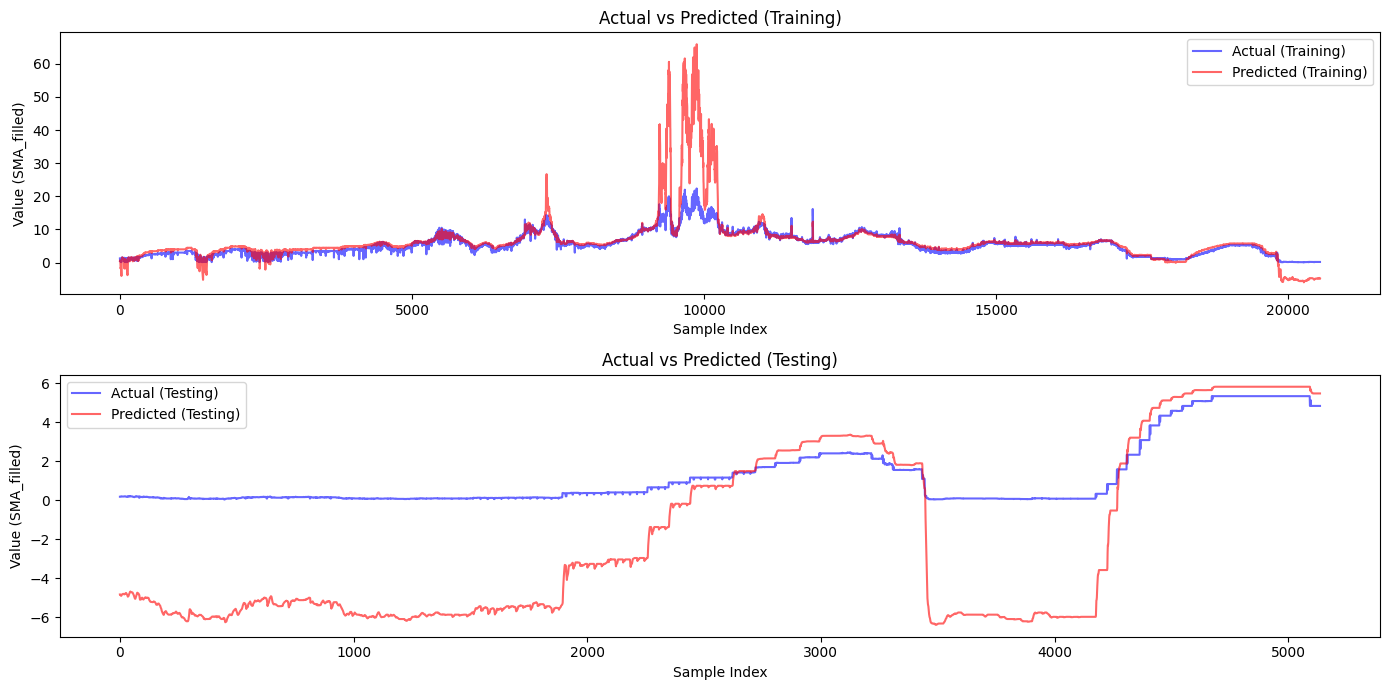

In [ ]:
# Plot Actual vs Predicted for Training and Testing Data

plt.figure(figsize=(14, 7))

# Plot for Training Data
plt.subplot(2, 1, 1)
plt.plot(y_train_inv, label='Actual (Training)', color='blue', alpha=0.6)
plt.plot(train_pred, label='Predicted (Training)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

# Plot for Testing Data
plt.subplot(2, 1, 2)
plt.plot(y_test_inv, label='Actual (Testing)', color='blue', alpha=0.6)
plt.plot(test_pred, label='Predicted (Testing)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

plt.tight_layout()
plt.show()

Model performed really well at predicting the rates. But further analysis is needed since this model might be overfitted and not generalized to unseen data.

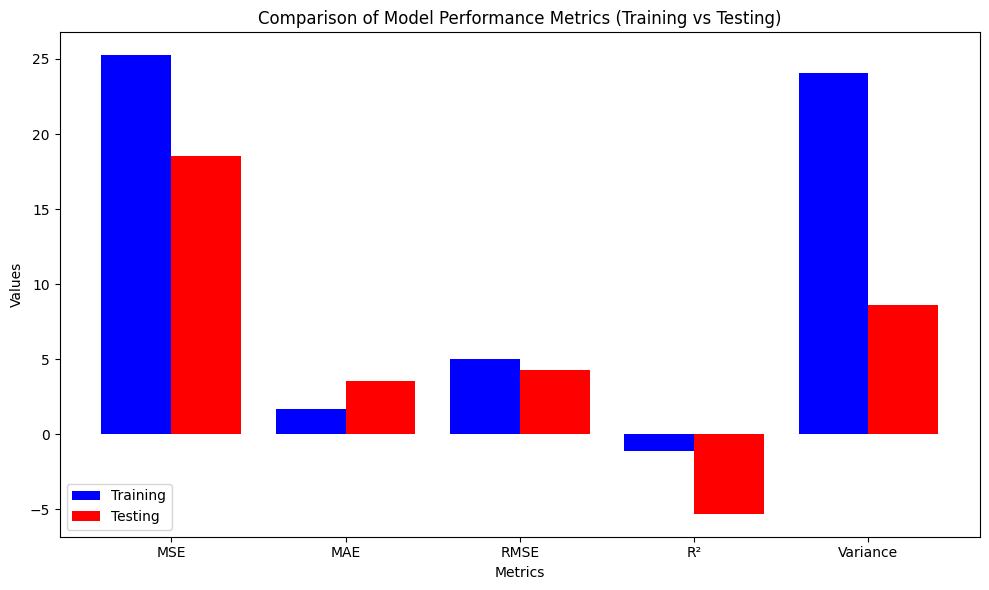

In [ ]:
# Bar plot to compare metrics for training and testing sets

metrics = ['MSE', 'MAE', 'RMSE', 'R²', 'Variance']
train_metrics = [train_mse, train_mae, train_rmse, train_r2, train_variance]
test_metrics = [test_mse, test_mae, test_rmse, test_r2, test_variance]

x = np.arange(len(metrics))

# Plotting comparison of metrics
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_metrics, 0.4, label='Training', color='blue')
plt.bar(x + 0.2, test_metrics, 0.4, label='Testing', color='red')

plt.title('Comparison of Model Performance Metrics (Training vs Testing)')
plt.xticks(x, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
plt.show()

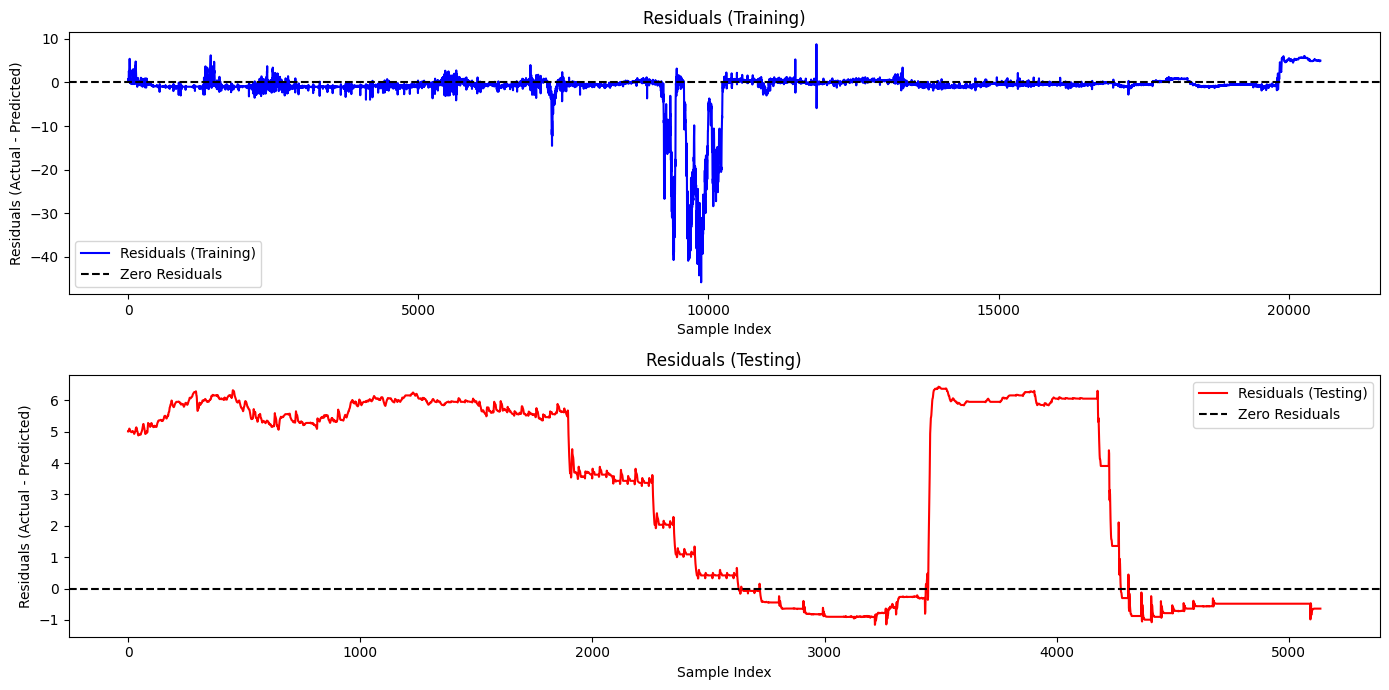

In [ ]:
# Calculate residuals for training and testing sets
train_errors = y_train_inv - train_pred
test_errors = y_test_inv - test_pred

# Residuals Plot (Training and Testing)
plt.figure(figsize=(14, 7))

# Training residuals plot
plt.subplot(2, 1, 1)
plt.plot(train_errors, label='Residuals (Training)', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

# Testing residuals plot
plt.subplot(2, 1, 2)
plt.plot(test_errors, label='Residuals (Testing)', color='red')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

plt.tight_layout()
plt.show()

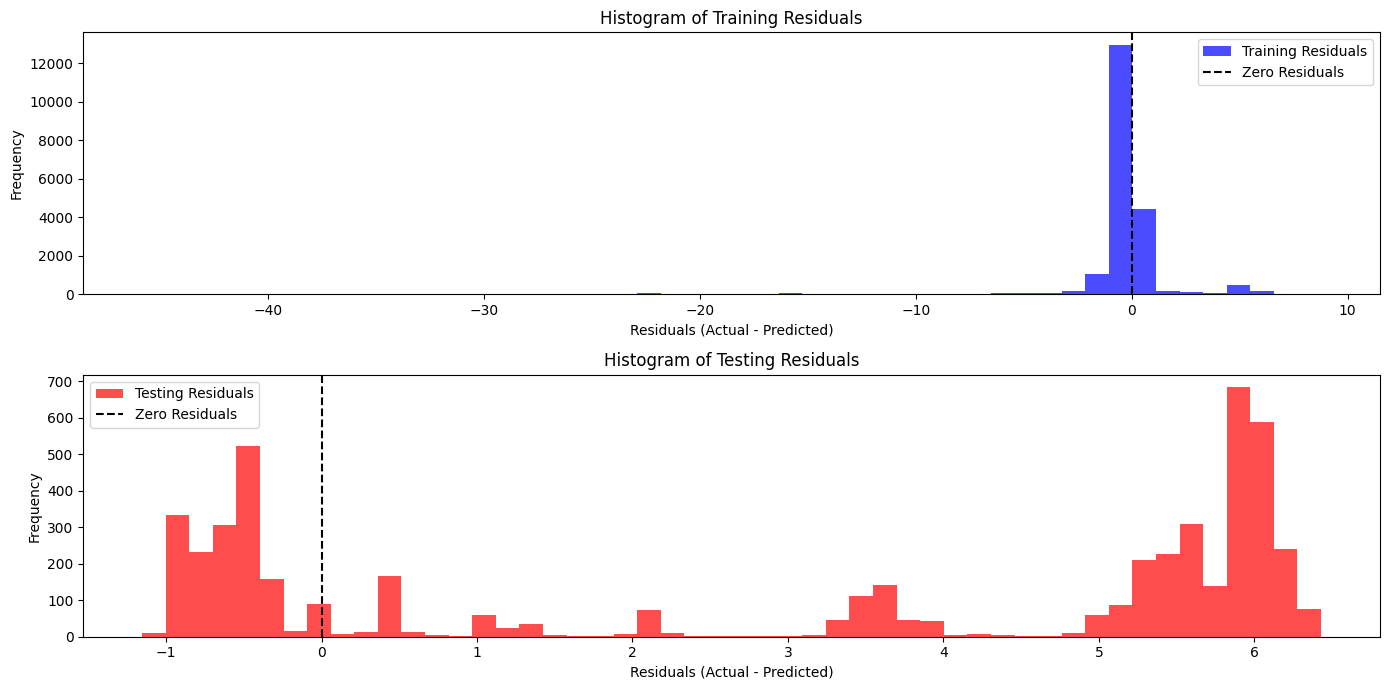

In [ ]:
# Histogram of residuals (errors) for training and testing
plt.figure(figsize=(14, 7))

# Training errors histogram
plt.subplot(2, 1, 1)
plt.hist(train_errors, bins=50, color='blue', alpha=0.7, label='Training Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Training Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

# Testing errors histogram
plt.subplot(2, 1, 2)
plt.hist(test_errors, bins=50, color='red', alpha=0.7, label='Testing Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Testing Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Print the model architecture summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 10, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 20)              │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 10)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,275 (36.23 KB)

 Trainable params: 3,071 (12.00 KB)

 Non-trainable params: 60 (240.00 B)

 Optimizer params: 6,144 (24.00 KB)

In [2]:
!pip install keras --upgrade
!pip install tensorflow --upgrade

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import randint, uniform
import numpy as np

# Define the PyTorch LSTM model
class LSTMModel(nn.Module):
    def __init__(self, units=20, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=units, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(units)

        self.lstm2 = nn.LSTM(input_size=units, hidden_size=units // 2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate * 2)
        self.bn2 = nn.BatchNorm1d(units // 2)

        self.fc = nn.Linear(units // 2, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x[:, -1, :])
        x = self.bn1(x)

        x, _ = self.lstm2(x.unsqueeze(1))
        x = self.dropout2(x[:, -1, :])
        x = self.bn2(x)

        x = self.fc(x)
        return x


# Function to train the model
def train_model(X_train, y_train, X_val, y_val, params):
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    # Initialize model, loss, and optimizer
    model = LSTMModel(units=params['units'], dropout_rate=params['dropout_rate'])
    criterion = nn.MSELoss()
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])

    # Training loop
    best_val_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(params['epochs']):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model


# Hyperparameter search function
def objective(params):
    global X_train, y_train, X_val, y_val
    model = train_model(X_train, y_train, X_val, y_val, params)
    model.eval()

    X_test_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()

    mse = mean_squared_error(y_val, predictions)
    return mse


# Define hyperparameter grid
param_distributions = {
    'optimizer': ['Adam', 'RMSprop', 'SGD'],
    'units': randint(10, 51),
    'dropout_rate': uniform(0.1, 0.5),
    'batch_size': [2, 4, 8],
    'epochs': randint(10, 51),
    'learning_rate': uniform(0.001, 0.01)
}

# Dummy dataset (replace with actual data)
X = np.random.randn(1000, 10)
y = np.random.randn(1000)

# Train-validation split
X_train, X_val = X[:800], X[800:]
y_train, y_val = y[:800], y[800:]

# Perform RandomizedSearchCV
from sklearn.model_selection import ParameterSampler
n_iter = 10
best_score = float('inf')
best_params = None

for params in ParameterSampler(param_distributions, n_iter=n_iter, random_state=42):
    print("Testing params:", params)
    score = objective(params)
    print(f"Validation MSE: {score:.4f}")
    if score < best_score:
        best_score = score
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best Validation MSE:", best_score)


Testing params: {'batch_size': 8, 'dropout_rate': 0.49827149343011645, 'epochs': 24, 'learning_rate': 0.008319939418114052, 'optimizer': 'Adam', 'units': 30}
Epoch 1: Train Loss: 0.9848, Val Loss: 4.7984
Epoch 2: Train Loss: 0.9717, Val Loss: 4.2572
Epoch 3: Train Loss: 0.9665, Val Loss: 1.0886
Epoch 4: Train Loss: 0.9716, Val Loss: 0.8509
Epoch 5: Train Loss: 0.9707, Val Loss: 0.8503
Epoch 6: Train Loss: 0.9681, Val Loss: 0.9199
Epoch 7: Train Loss: 0.9677, Val Loss: 0.8437
Epoch 8: Train Loss: 0.9644, Val Loss: 0.9010
Epoch 9: Train Loss: 0.9692, Val Loss: 0.8962
Epoch 10: Train Loss: 0.9654, Val Loss: 0.9491
Epoch 11: Train Loss: 0.9661, Val Loss: 7.8145
Epoch 12: Train Loss: 0.9694, Val Loss: 0.8557
Early stopping triggered.
Validation MSE: 0.8557
Testing params: {'batch_size': 8, 'dropout_rate': 0.3229163764267956, 'epochs': 32, 'learning_rate': 0.0015808361216819947, 'optimizer': 'Adam', 'units': 45}
Epoch 1: Train Loss: 1.1699, Val Loss: 0.8814
Epoch 2: Train Loss: 1.0781, Val L

Final LSTM with the best hyperparameters:

Best Hyperparameters:
batch_size: 8,
dropout_rate: 0.11029224714790123,
epochs: 11,
learning_rate: 0.008219987722668248,
optimizer: RMSprop,
units: 47


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.1509 - val_loss: 0.0018
Epoch 2/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 3/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0051 - val_loss: 2.6069e-04
Epoch 4/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 5/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0048 - val_loss: 0.0078
Epoch 6/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0048 - val_loss: 1.1426e-04
Epoch 7/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0049 - val_loss: 4.4370e-04
Epoch 8/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0047 - val_loss: 0.0132
Epoch 9/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 10/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.0046 - val_loss: 6.2833e-04
Epoch 11/11
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 0.0045 - val_loss:

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 10, 47)              │           9,212 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 47)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 10, 47)              │             188 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 47)                  │          17,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 47)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 47)                  │             188 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              48 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,806 (214.09 KB)

 Trainable params: 27,308 (106.67 KB)

 Non-trainable params: 188 (752.00 B)

 Optimizer params: 27,310 (106.68 KB)

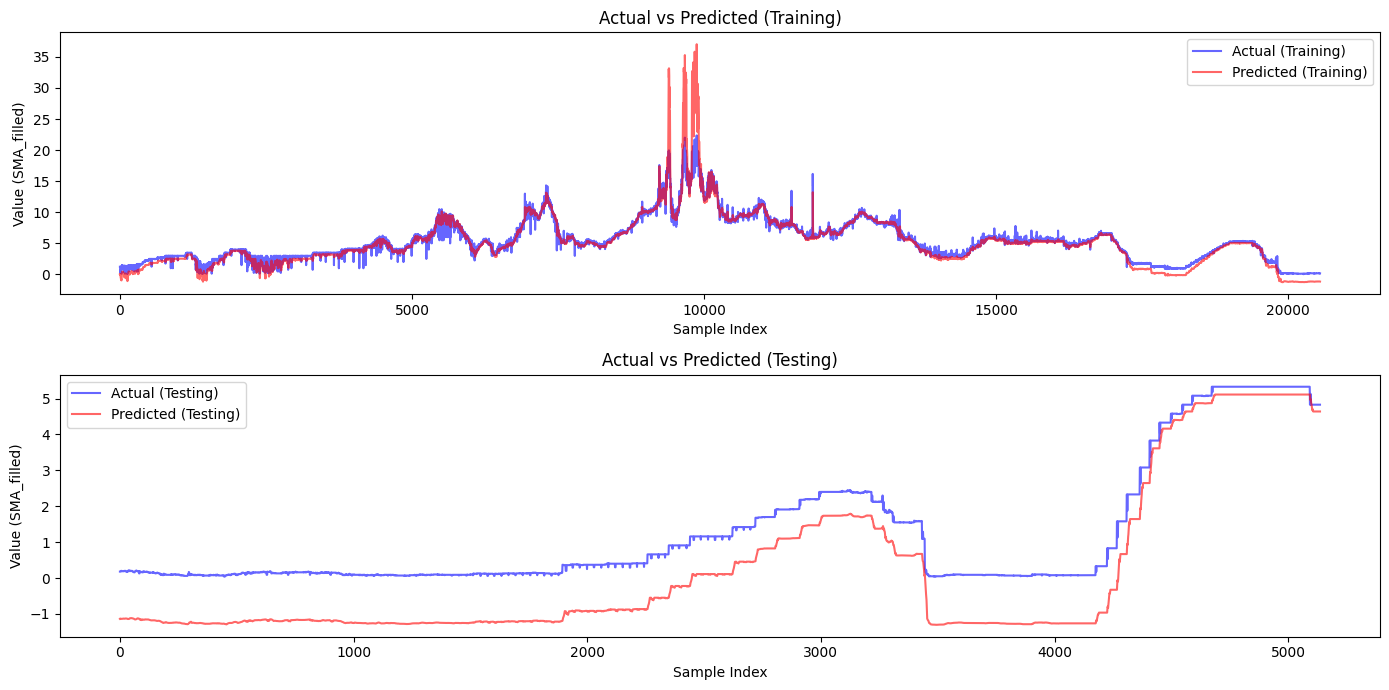

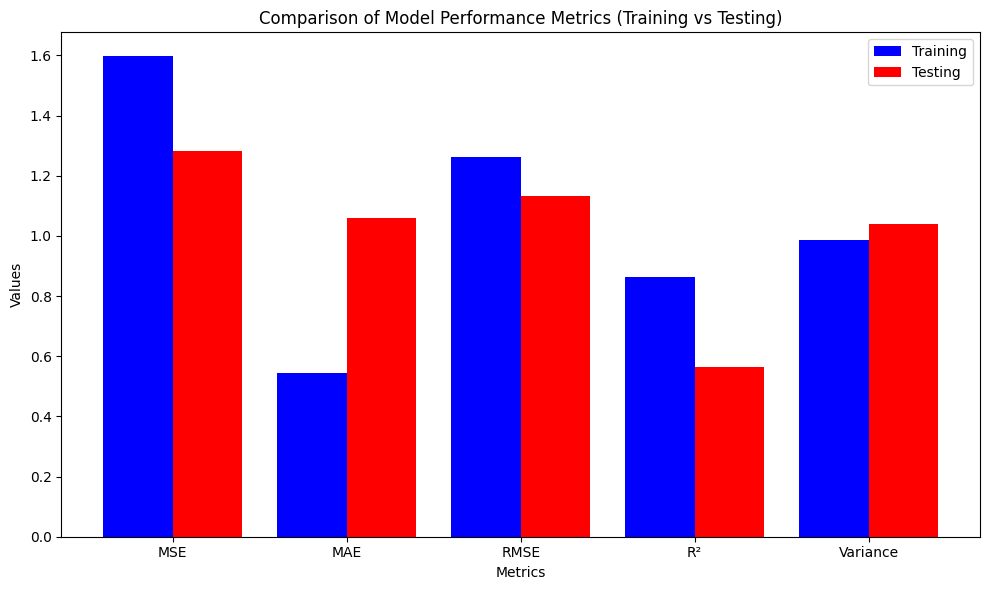

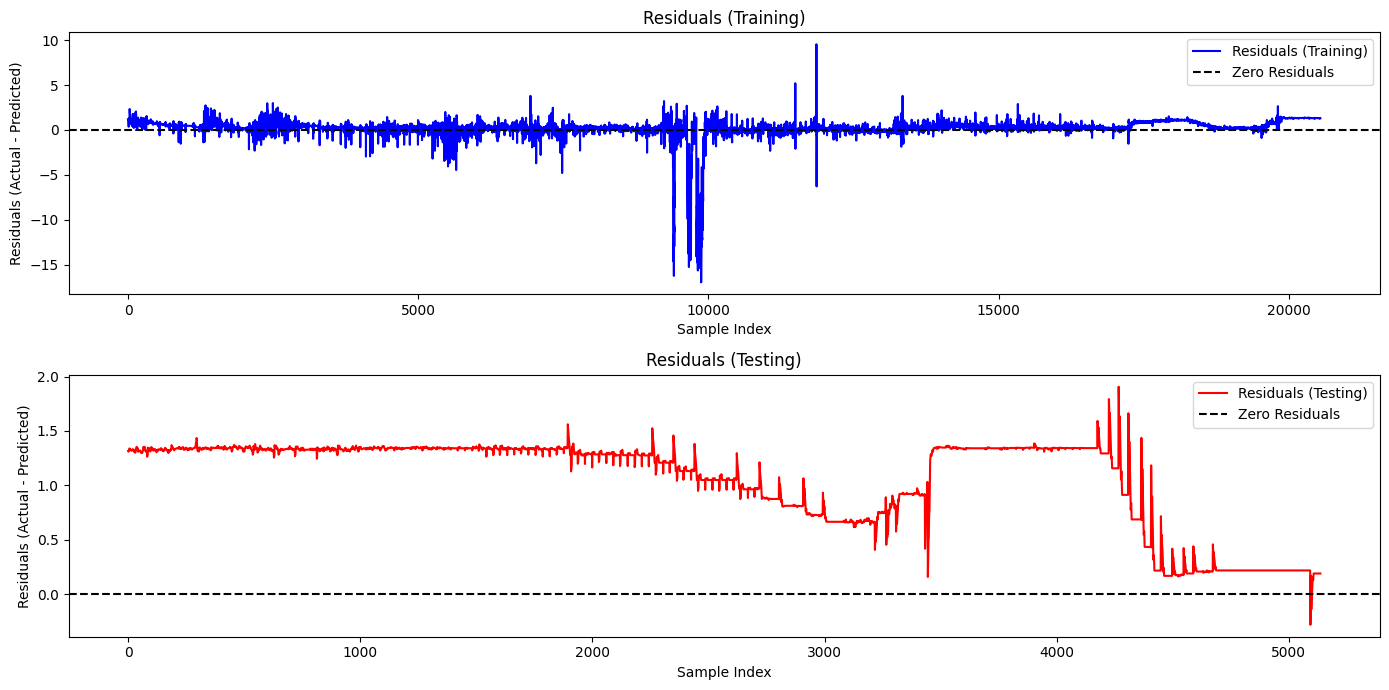

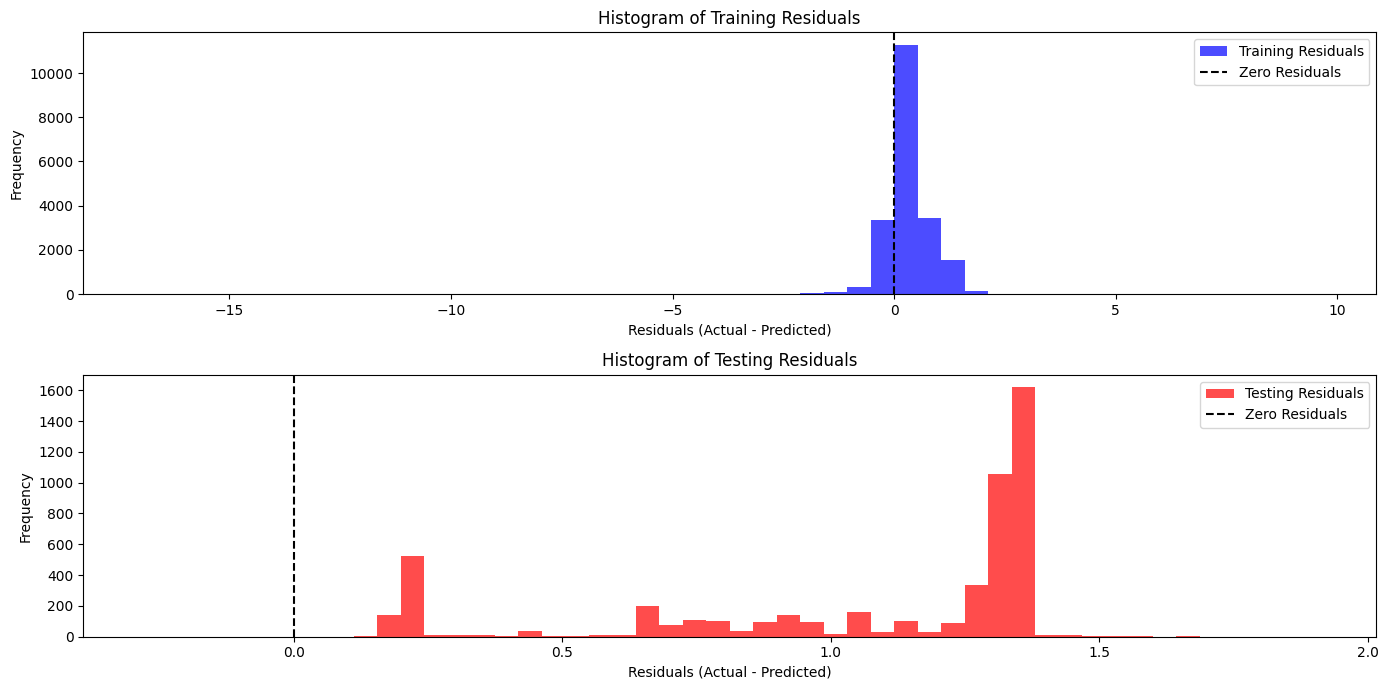

In [16]:
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import Dense

# Create sequences for LSTM
timesteps = 10
X = []
y = []

# Create sequences (X) and target values (y)
for i in range(timesteps, len(df)):
    X.append(df['SMA_filled_normalized'][i-timesteps:i].values)
    y.append(df['SMA_filled_normalized'][i])
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X_train and X_test into 3D arrays (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the model
model = Sequential()

# LSTM layer 1 with dropout and batch normalization
model.add(LSTM(units=47, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1102922))
model.add(BatchNormalization())

# LSTM layer 2 with dropout and batch normalization
model.add(LSTM(units=47))
model.add(Dropout(0.1102922))
model.add(BatchNormalization())

# Output layer
model.add(Dense(units=1))

# Compile the model with optimizer and loss function
optimizer = RMSprop(learning_rate= 0.00821998)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model (no early stopping)
model.fit(X_train, y_train, epochs=11, batch_size=8, verbose=1, validation_split=0.2)

# Predict using the trained model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Reshape predictions to 2D for inverse transformation
train_pred = train_pred.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)

# Inverse transform predictions and actual values to get them back to the original scale
scaler = MinMaxScaler()
scaler.fit(df['SMA_filled'].values.reshape(-1, 1))
train_pred = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train_inv, train_pred)
test_mse = mean_squared_error(y_test_inv, test_pred)

# Calculate Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_inv, train_pred)
test_mae = mean_absolute_error(y_test_inv, test_pred)

# Calculate Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate R-squared (R²)
train_r2 = r2_score(y_train_inv, train_pred)
test_r2 = r2_score(y_test_inv, test_pred)

# Calculate Variance of the errors (Residuals)
train_variance = np.var(y_train_inv - train_pred)
test_variance = np.var(y_test_inv - test_pred)

# Print metrics
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing Mean Squared Error: {test_mse}')
print(f'Training Mean Absolute Error (MAE): {train_mae}')
print(f'Testing Mean Absolute Error (MAE): {test_mae}')
print(f'Training Root Mean Squared Error (RMSE): {train_rmse}')
print(f'Testing Root Mean Squared Error (RMSE): {test_rmse}')
print(f'Training R-squared (R²): {train_r2}')
print(f'Testing R-squared (R²): {test_r2}')
print(f'Training Variance of Errors: {train_variance}')
print(f'Testing Variance of Errors: {test_variance}')

# Print the model architecture summary
model.summary()

# Plot Actual vs Predicted for Training and Testing Data
plt.figure(figsize=(14, 7))

# Plot for Training Data
plt.subplot(2, 1, 1)
plt.plot(y_train_inv, label='Actual (Training)', color='blue', alpha=0.6)
plt.plot(train_pred, label='Predicted (Training)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

# Plot for Testing Data
plt.subplot(2, 1, 2)
plt.plot(y_test_inv, label='Actual (Testing)', color='blue', alpha=0.6)
plt.plot(test_pred, label='Predicted (Testing)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

plt.tight_layout()
plt.show()

#Bar plot to compare metrics for training and testing sets

metrics = ['MSE', 'MAE', 'RMSE', 'R²', 'Variance']
train_metrics = [train_mse, train_mae, train_rmse, train_r2, train_var]
test_metrics = [test_mse, test_mae, test_rmse, test_r2, test_var]

x = np.arange(len(metrics))  # X-axis positions

# Plotting comparison of metrics
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_metrics, 0.4, label='Training', color='blue')
plt.bar(x + 0.2, test_metrics, 0.4, label='Testing', color='red')

plt.title('Comparison of Model Performance Metrics (Training vs Testing)')
plt.xticks(x, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate residuals
train_errors = y_train_inv.flatten() - train_pred.flatten()
test_errors = y_test_inv.flatten() - test_pred.flatten()

# Residuals Plot (Training and Testing)
plt.figure(figsize=(14, 7))

# Training residuals plot
plt.subplot(2, 1, 1)
plt.plot(train_errors, label='Residuals (Training)', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

# Testing residuals plot
plt.subplot(2, 1, 2)
plt.plot(test_errors, label='Residuals (Testing)', color='red')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate residuals
train_errors = y_train_inv.flatten() - train_pred.flatten()
test_errors = y_test_inv.flatten() - test_pred.flatten()

# Histogram of residuals (errors) for training and testing
plt.figure(figsize=(14, 7))

# Training errors histogram
plt.subplot(2, 1, 1)
plt.hist(train_errors, bins=50, color='blue', alpha=0.7, label='Training Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Training Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

# Testing errors histogram
plt.subplot(2, 1, 2)
plt.hist(test_errors, bins=50, color='red', alpha=0.7, label='Testing Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Testing Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()